In [95]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import string
import os

from keras.layers            import Activation, Dense, Dropout
from keras.models            import Sequential
from keras.optimizers        import SGD
from keras.utils.np_utils    import to_categorical
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import accuracy_score, confusion_matrix 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.svm             import SVC                                             as SVM
from sklearn.tree            import DecisionTreeClassifier                          as Tree

from utility                import plot_confusion_matrix, plot_img_dataset, plot_learning_curve, load_hyperopt_out

# 4. Reconocimiento de Imágenes Sign Gestures

En esta sección, se estudiará el comportamiento de distintos modelos en la tarea de clasificar imágenes, en especifico se utilizará el conjunto de imágenes Sign Language MNIST, este conjunto de imágenes se compone de imágenes de 28x28 pixeles, donde cada imagen corresponde a la representación de las letras del abecedario en el lenguaje de señas. El conjunto se compone de 27455 imágenes para el conjunto de entrenamiento y 7172 para el conjunto de pruebas. Cada imagen del conjunto pertenece a una única etiqueta, la cual pertenece al conjunto de números enteros [0, 25], y corresponden a cada letra del abecedario (A-Z). Dadas las limitaciones de la representación del conjunto de imágenes se incluyen, no se incluyen imágenes con las etiquetas 9 (J) y 25 (Z), debido a que estas letras incluyen movimiento en su representación. 

A continuación se muestran algunos elementos del conjunto de imágenes,  agrupados por etiqueta.

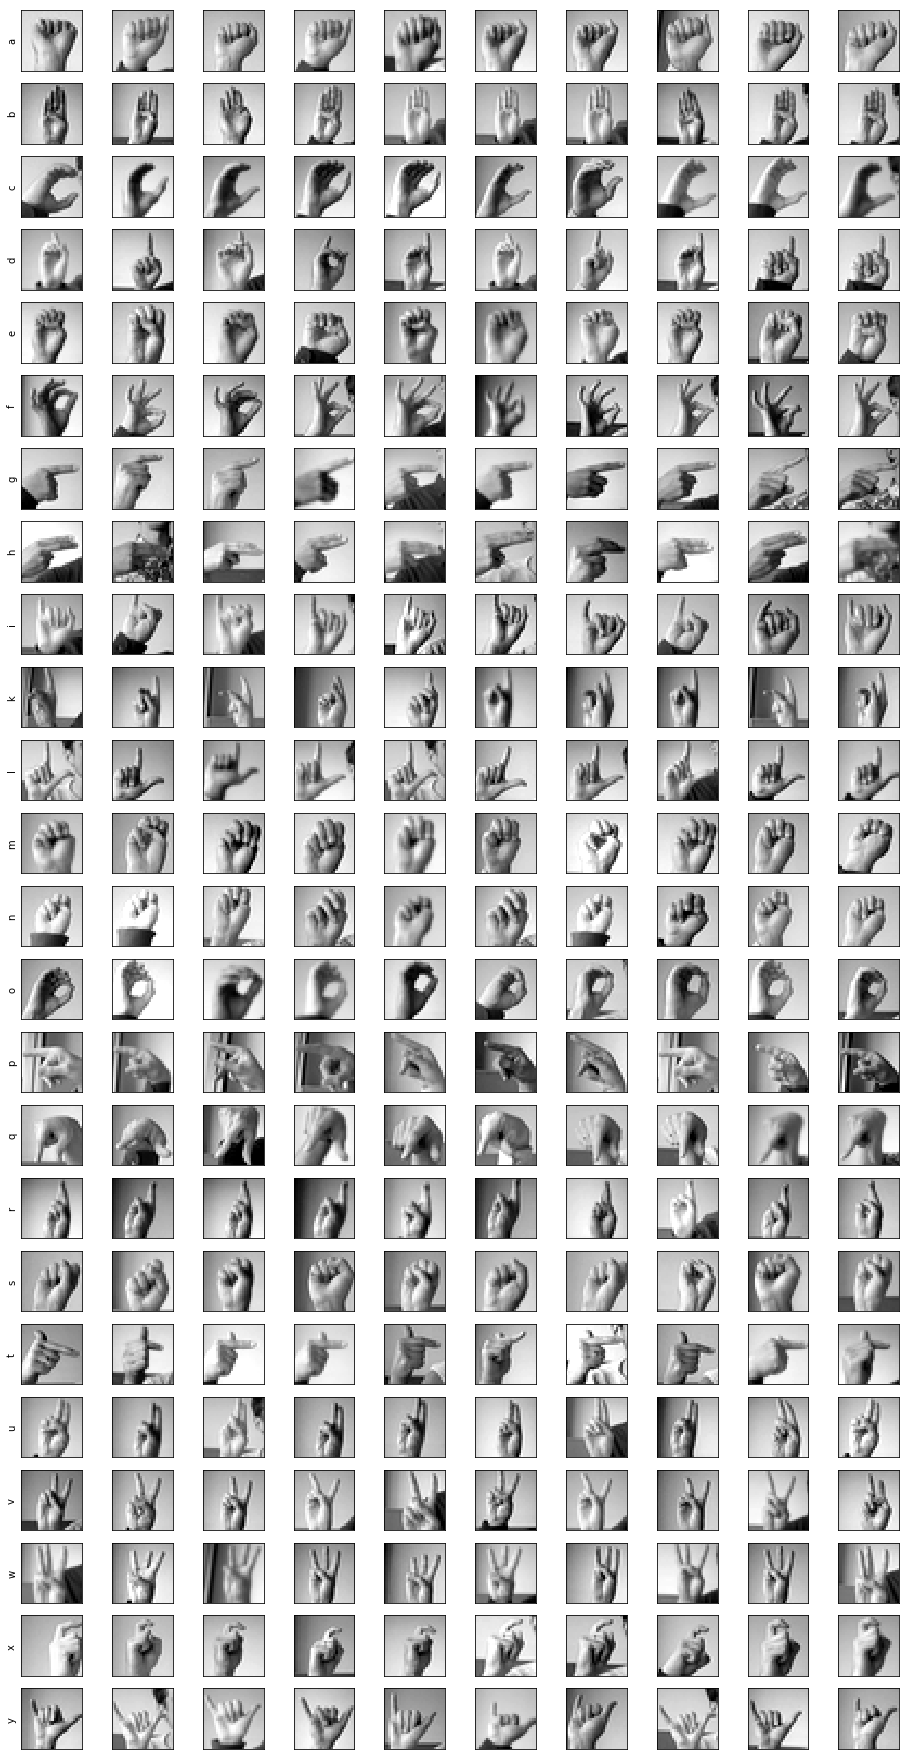

In [4]:
plot_img_dataset(x_tr, y_tr, labels, classes_names=labels_names, _figsize=(16, 32))

Ha de señalarse que el conjunto de imágenes fue generado a partir de un conjunto más pequeño (1704 elementos), y para aumentar la cantidad de registros se aplicaron diversas estrategias, entre las cuales se encuentran: aplicar filtros ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), realizar un 5% de pixelacion automática, modificación en un +/- 15% en el brillo o el contraste, y una rotación en 3 grados. Las trasformaciones anteriores se consideran efectivas para crear nuevos ejemplos de las clases debido al pequeño tamaño de las imágenes, permitiendo una mejor separación de las clases. 

## a) Construya una función que cargue todos los datos de entrenamiento y pruebas del problema generando como salida: 
1. Dos matrices Xtr; Ytr, correspondientes a las imágenes y etiquetas de entrenamiento.
2. Dos matrices Xt; Yt, correspondientes a las imágenes y etiquetas de pruebas.
3. Dos matrices Xv; Yv, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo.

Se crea la función load_data, la cual se encarga de generar los conjuntos de entrenamiento, pruebas y validación, este ultimo si es generado se genera con un 25% de los datos del conjunto de entrenamiento. La función posee los siguientes parámetros:
- base_path: Ruta donde se encuentran los archivos del conjunto de datos, por defecto es ‘data/sign-language-mnist’
- test: Si se genera el conjunto de testeo, por defecto True.
- validation: Si se genera el conjunto de validación, por defecto True.

In [2]:
def load_data(base_path = os.path.join('data', 'sign-language-mnist'), validation=True, test=True):
    # read train set
    train_data = pd.read_csv(os.path.join(base_path,  'sign_mnist_train.csv'))
    y_tr = train_data['label'].as_matrix()
    x_tr = train_data.iloc[:,1:].as_matrix()
    out = [x_tr, y_tr]
    # read test set
    if test:
        test_data = pd.read_csv(os.path.join(base_path,  'sign_mnist_test.csv'))
        y_t = test_data['label'].as_matrix()
        x_t = test_data.iloc[:,1:].as_matrix()
        out.append(x_t)
        out.append(y_t)
    # split train set into train and validation set
    if validation:
        x_tr, x_v, y_tr, y_v = train_test_split(x_tr, y_tr, test_size=0.25, random_state=42)
        out[0] = x_tr
        out[1] = y_tr
        out.append(x_v)
        out.append(y_v)
    return tuple(out)

In [45]:
x_tr, y_tr, x_t, y_t, x_v, y_v = load_data()
x_tr_f, y_tr_f = load_data(validation=False, test=False)

Se generan los conjuntos de entrenamiento, pruebas y validación. Los conjuntos generados no poseen elementos en común, además el tamaño de estos es $20591$ registros para el conjunto de entrenamiento, $7172$ para el conjunto de pruebas y $6864$ para el conjunto de validación.

Finalmente se genera un conjunto de entrenamiento con todos los elementos del archivo ‘sign_mnist_train.csv’. Este conjunto será utilizado para entrenar los modelos finales o los entrenados mediante k-fold validation.

In [4]:
# Conjunto de etiquetas del problema
labels = list(set(y_t))
labels_names = [i for i in string.ascii_lowercase]
labels_names.remove('j')
labels_names.remove('z')

## b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente sólo escalando los datos de acuerdo a la intensidad máxima de pixel y luego centrando y escalándolos como en actividades anteriores.


Se crea la función scaler_function, la cual por defecto  la intensidad de los pixeles de la imagen dividiéndolos en 255, con el objetivo de que la intensidad por pixel pertenezca al intervalo [0, 1]. La función también permite centrar y escalar la los datos, utilizando un StandardScaler, si el parámetro scale es verdadero se escalaran y centraran los datos, si el parámetro std es falso solo se escalaran.

In [5]:
def scaler_function(x_train, x_test=None, x_val=None, scale=False, std=True):
    x_train = x_train.astype('float64')
    x_train /= 255.
    scaler = StandardScaler(with_std=std).fit(x_train)
    if scale:
        x_train = scaler.transform(x_train)
    out = [x_train]
    if not x_test is None:
        x_test = x_test.astype('float64')
        x_test /= 255.
        if scale:
            x_test = scaler.transform(x_test)
        out.append(x_test)
    if not x_val is None:
        x_val = x_val.astype('float64')
        x_val /= 255.
        if scale:
            x_val = scaler.transform(x_val)
        out.append(x_val)
    return tuple(out) if 1<len(out) else out[0]

Se ajustan las intensidades de los 4 conjuntos anteriormente creados:

In [6]:
# Conjuntos usados para evaluar
x_train, x_test, x_val = scaler_function(x_tr, x_t, x_v)
# Conjunto usados para el entrenamiento del modelo 'final'
x_train_full = scaler_function(x_tr_f)

Además, se crean otros cuatro conjuntos a partir de los conjuntos originales. A los nuevos conjuntos se les ajusta la intensidad, y se escalan utilizando el StandardScaler. 

In [19]:
x_train_center, x_val_center, x_test_center = scaler_function(x_tr, x_v, x_t, scale=True)
x_train_full_center = scaler_function(x_tr_f, scale=True)

## c) Diseñe, entrene y evalúe una red neuronal para el problema partir de la representación original de las imágenes. Experimente con distintas arquitecturas, pre-procesamientos y métodos de entrenamiento, midiendo el error de clasificación sobre el conjunto de validación. En base a esta última medida de desempeño, decida que modelo, de entre todos los evaluados, medirá finalmente en el conjunto de test. Reporte y discuta los resultados obtenidos. 

Para determinar que arquitectura y elección de preprocesamiento es la mas adecuada para resolver el problema de clasificar las imágenes del conjunto de datos, primero se enfocaron los esfuerzos en determinar que estructuras o patrones de estructuras son beneficiosos para la resolución del problema. 

La primera tarea realizada consistió en utilizar la librería *Hyperas*, la cual es un sintonizador de parámetros para modelos de redes neuronales basados en la librería *Keras*. Utilizando el conjunto de datos, donde la intensidad de cada pixel fue dividida por 255, se entrenaron 75 redes neuronales, de las cuales los parámetros a sintonizar fueron:
- Tamaño de la primera capa, valor numérico con las opciones (30, 45, 60) neuronas.
- Función de activación primera capa, donde las opciones posibles fueron [relu, elu]
- Tamaño de la segunda capa, con las mismas opciones que la primera capa.
- Función de activación de la segunda capa, con las mismas opciones de la primera capa.
- Si se agrega una tercera capa, valor booleano (True, False)
- Si se agrega una tercera capa, el tamaño de estas con las mismas opciones de las capas anteriores.
- Si se agrega una tercera capa, la función de activación de esta, con las mismas opciones que las capas anteriores.
- Optimizador a utilizar en el entrenamiento de la red, donde las opciones fueron rmsprop, adam, sgd.
- El tamaño del batch utilizado para actualizar los pesos de la red, donde los valores posibles fueron 64 y 128.

Para la elección de las mejores estructuras se utilizó el conjunto de validación, previamente construido. Y el código correspondiente se encuentra en el archivo ‘test.py’ ya que no fue posible ejecutar satisfactoriamente la librería en el notebook.

A continuación, se muestran algunos de los mejores resultados obtenidos. A de señalarse que siempre están presente los valores del tamaño y función de activación de la tercera capa, pero si no se eligió agregar dicha capa, estos valores no se tienen en cuenta.

In [12]:
import pprint

hyp_out = load_hyperopt_out('trial.json')
pprint.pprint(hyp_out[0])
pprint.pprint(hyp_out[2])
pprint.pprint(hyp_out[4])
pprint.pprint(hyp_out[6])
pprint.pprint(hyp_out[8])

{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.2504909167727587,
          'Dropout_1': 0.04055836586938495,
          'Dropout_2': 0.7170109682276645,
          'activation': 'elu',
          'activation_1': 'relu',
          'activation_2': 'relu',
          'batch_size': 128,
          'conditional': False,
          'optimizer': 'adam'},
 'loss': -0.9998543123543123}
{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.26575371035061834,
          'Dropout_1': 0.0638174825649742,
          'Dropout_2': 0.8560325910603621,
          'activation': 'elu',
          'activation_1': 'relu',
          'activation_2': 'relu',
          'batch_size': 128,
          'conditional': False,
          'optimizer': 'adam'},
 'loss': -0.9997086247086248}
{'conf': {'Dense': 45,
          'Dense_1': 60,
          'Dense_2': 60,
          'Dropout': 0.21772733016930734,
          'Dropout_1': 0.31899443452607

In [94]:
def build_model(conf, _input_dim):
    model = Sequential()
    model.add(Dense(conf['Dense'][0], input_dim=_input_dim, activation=conf['activation'][0], kernel_initializer='uniform'))
    model.add(Dropout(conf['Dropout'][0]))
    for i in range(1,conf['layers']):
        model.add(Dense(conf['Dense'][i], activation=conf['activation'][i], kernel_initializer='uniform'))
        model.add(Dropout(conf['Dropout'][i]))
    model.add(Dense(25, activation='softmax', kernel_initializer='uniform'))
    # Compile model
    model.compile(optimizer=conf['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
list_conf = [
    { 
        'id': 0, 'layers': 2, 'Dense': [128, 64], 'Dropout': [.20, .15],
        'activation': ['elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 1, 'layers': 3, 'Dense': [256, 128, 64], 'Dropout': [.25, .20, .15],
        'activation': ['elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 2, 'layers': 4, 'Dense': [512, 256, 128, 64], 'Dropout': [.30, .25, .20, .15],
        'activation': ['elu','elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 3, 'layers': 4, 'Dense': [512, 256, 128, 64], 'Dropout': [.25, .20, .15, .10],
        'activation': ['elu','elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
]

In [110]:
list_conf1 = [
    { 
        'id': 0, 'layers': 2, 'Dense': [30, 30], 'Dropout': [0, 0],
        'activation': ['relu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 1, 'layers': 2, 'Dense': [30, 30], 'Dropout': [0, 0],
        'activation': ['elu', 'elu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 2, 'layers': 2, 'Dense': [30, 30], 'Dropout': [0, 0],
        'activation': ['elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
    { 
        'id': 3, 'layers': 4, 'Dense': [512, 256, 128, 64], 'Dropout': [.25, .20, .15, .10],
        'activation': ['elu','elu', 'elu', 'relu'], 'batch_size': 128, 'optimizer': 'adam'
    },
]

In [109]:
def eval_models(list_conf, splits=5):
    n_conf = len(list_conf)
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=44)
    base = ' - '
    hist = [[] for _ in range(n_conf)]
    for conf in list_conf:
        cvscores = []
        loss_out = None
        acc_out = None
        for train, test in kfold.split(x_train_full, y_tr_f):
            model = build_model(conf, x_train.shape[1])
            history = model.fit(x_train_full[train], to_categorical(y_tr_f[train]), epochs=100, batch_size=128, verbose=0,
                       validation_data=(x_train_full[test], to_categorical(y_tr_f[test])))
            hist[conf['id']].append(history)
            # evaluate the model
            scores = model.evaluate(x_train_full[test], to_categorical(y_tr_f[test]), verbose=0)
            cvscores.append(scores[1]*100)
            acc_cur = "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)
            acc_out = base.join([acc_out, acc_cur]) if acc_out else acc_cur
            loss_cur = "%s: %.3f" % (model.metrics_names[0], scores[0])
            loss_out = base.join([loss_out, loss_cur]) if loss_out else loss_cur
        print('--------------------------- 5-fold id: %i ---------------------------' % conf['id'])
        print(loss_out)
        print(acc_out)
        print("acc fold: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return hist

In [111]:
eval_models(list_conf1)

--------------------------- 5-fold id: 0 ---------------------------
loss: 0.064 - loss: 0.019 - loss: 0.054 - loss: 0.083 - loss: 0.064
acc: 98.56% - acc: 99.80% - acc: 99.03% - acc: 98.21% - acc: 99.16%
acc fold: 98.95% (+/- 0.54%)
--------------------------- 5-fold id: 1 ---------------------------
loss: 0.005 - loss: 0.005 - loss: 0.022 - loss: 0.003 - loss: 0.080
acc: 99.91% - acc: 99.96% - acc: 99.54% - acc: 100.00% - acc: 97.15%
acc fold: 99.31% (+/- 1.09%)
--------------------------- 5-fold id: 2 ---------------------------
loss: 0.013 - loss: 0.007 - loss: 0.006 - loss: 0.009 - loss: 0.025
acc: 99.84% - acc: 99.93% - acc: 99.93% - acc: 99.89% - acc: 99.51%
acc fold: 99.82% (+/- 0.16%)
--------------------------- 5-fold id: 3 ---------------------------
loss: 0.005 - loss: 0.006 - loss: 0.001 - loss: 0.005 - loss: 0.000
acc: 99.84% - acc: 99.87% - acc: 100.00% - acc: 99.85% - acc: 100.00%
acc fold: 99.91% (+/- 0.07%)


[[<keras.callbacks.History at 0x1aa5594da58>,

In [98]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
base = ' - '
hist = [[] for _ in range(4)]

for conf in list_conf:
    cvscores = []
    loss_out = None
    acc_out = None
    for train, test in kfold.split(x_train_full, y_tr_f):
        model = build_model(conf, x_train.shape[1])
        history = model.fit(x_train_full[train], to_categorical(y_tr_f[train]), epochs=100, batch_size=128, verbose=0,
                   validation_data=(x_train_full[test], to_categorical(y_tr_f[test])))
        hist[conf['id']].append(history)
        # evaluate the model
        scores = model.evaluate(x_train_full[test], to_categorical(y_tr_f[test]), verbose=0)
        cvscores.append(scores[1]*100)
        acc_cur = "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)
        acc_out = base.join([acc_out, acc_cur]) if acc_out else acc_cur
        loss_cur = "%s: %.3f" % (model.metrics_names[0], scores[0])
        loss_out = base.join([loss_out, loss_cur]) if loss_out else loss_cur
    print('--------------------------- 5-fold id: %i ---------------------------' % conf['id'])
    print(loss_out)
    print(acc_out)
    print("acc fold: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

--------------------------- 5-fold id: 0 ---------------------------
loss: 0.004 - loss: 0.004 - loss: 0.009 - loss: 0.005 - loss: 0.003
acc: 99.91% - acc: 99.96% - acc: 99.80% - acc: 99.95% - acc: 100.00%
acc fold: 99.92% (+/- 0.07%)
--------------------------- 5-fold id: 1 ---------------------------
loss: 0.001 - loss: 0.001 - loss: 0.005 - loss: 0.004 - loss: 0.013
acc: 100.00% - acc: 100.00% - acc: 99.87% - acc: 99.98% - acc: 99.47%
acc fold: 99.87% (+/- 0.20%)
--------------------------- 5-fold id: 2 ---------------------------
loss: 0.001 - loss: 0.024 - loss: 0.003 - loss: 0.001 - loss: 0.001
acc: 100.00% - acc: 99.33% - acc: 99.95% - acc: 99.96% - acc: 100.00%
acc fold: 99.85% (+/- 0.26%)
--------------------------- 5-fold id: 3 ---------------------------
loss: 0.003 - loss: 0.003 - loss: 0.002 - loss: 0.002 - loss: 0.005
acc: 99.93% - acc: 99.93% - acc: 99.95% - acc: 99.96% - acc: 99.89%
acc fold: 99.93% (+/- 0.02%)


In [100]:
def plot_learning_curve(history_fold):
    n_plots = len(history_fold)
    x = len(hist[0][0].history['acc'])
    x_space = np.linspace(1, x, x)

    f, axarr = plt.subplots(n_plots, 2,figsize=(16,5*n_plots))
    for i in range(n_plots):
        train_acc = [hist[i][j].history['acc'] for j in range(5)]
        train_loss = [hist[i][j].history['loss'] for j in range(5)]
        val_acc = [hist[i][j].history['val_acc'] for j in range(5)]
        val_loss = [hist[i][j].history['val_loss'] for j in range(5)]

        train_acc_mean = np.mean(train_acc, axis=0)
        train_acc_std = np.std(train_acc, axis=0)
        train_loss_mean = np.mean(train_loss, axis=0)
        train_loss_std = np.std(train_loss, axis=0)
        val_acc_mean = np.mean(val_acc, axis=0)
        val_acc_std = np.std(val_acc, axis=0)
        val_loss_mean = np.mean(val_loss, axis=0)
        val_loss_std = np.std(val_loss, axis=0)

        axarr[i, 0].grid(True, linestyle='dashed')
        axarr[i, 0].fill_between(x_space, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.25, color="r")
        axarr[i, 0].fill_between(x_space, val_acc_mean - val_acc_std, val_acc_mean + train_acc_std, alpha=0.25, color="g")
        axarr[i, 0].plot(x_space, train_acc_mean, marker='.', linestyle='--', color="r", label="Training score")
        axarr[i, 0].plot(x_space, val_acc_mean, marker='.', linestyle='--', color="g", label="Cross-validation score")
        axarr[i, 0].set_xlabel('epoch')
        axarr[i, 0].set_ylabel('accuracy')
        axarr[i, 0].legend(loc='lower right')
        
        axarr[i, 1].grid(True, linestyle='dashed')
        axarr[i, 1].fill_between(x_space, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.25, color="r")
        axarr[i, 1].fill_between(x_space, val_loss_mean - val_loss_std, val_loss_mean + train_loss_std, alpha=0.25, color="g")
        axarr[i, 1].plot(x_space, train_loss_mean, marker='.', linestyle='--', color="r", label="Training score")
        axarr[i, 1].plot(x_space, val_loss_mean, marker='.', linestyle='--', color="g", label="Cross-validation score")
        axarr[i, 1].set_xlabel('epoch')
        axarr[i, 1].set_ylabel('loss')
        axarr[i, 1].legend(loc='upper right')
    plt.show()
    

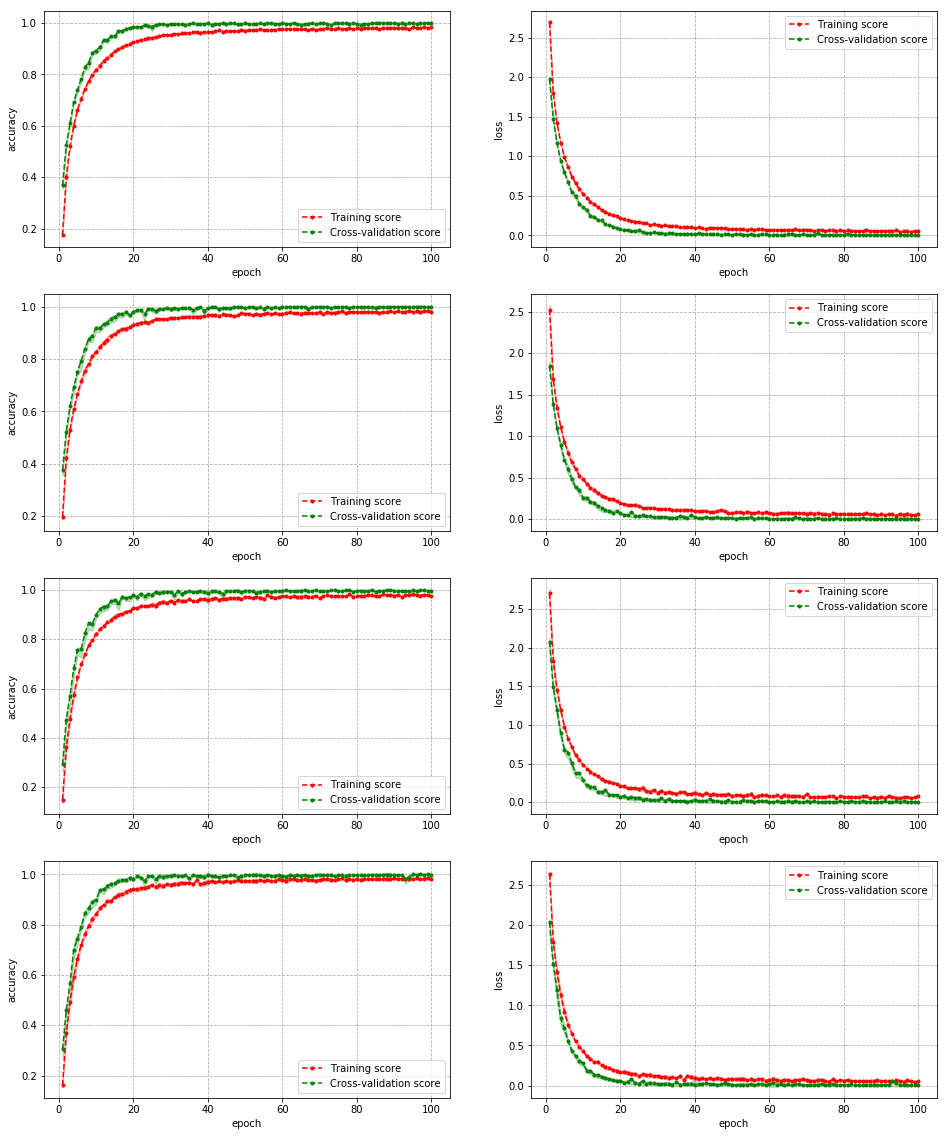

In [101]:
plot_learning_curve(hist)

In [106]:
# x scales
best_conf = {
    'layers': 4,
    'Dense': [512, 256, 128, 64],
    'Dropout': [.25, .25, .20, .15],
    'activation': ['elu','elu', 'elu', 'relu'],
    'batch_size': 128,
    'optimizer': 'adam'
}

model = build_model(best_conf, x_train.shape[1])
model.summary()
history = model.fit(x_train_full_center, to_categorical(y_tr_f), epochs=100, batch_size=128, verbose=2,
                   validation_data=(x_test_center, to_categorical(y_t)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_338 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_260 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_339 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_261 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_340 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_262 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 64)                8256      
__________

Epoch 79/100
 - 8s - loss: 0.0265 - acc: 0.9950 - val_loss: 1.5821 - val_acc: 0.8341
Epoch 80/100
 - 8s - loss: 0.0134 - acc: 0.9968 - val_loss: 1.5202 - val_acc: 0.8362
Epoch 81/100
 - 8s - loss: 0.0256 - acc: 0.9949 - val_loss: 1.7143 - val_acc: 0.8172
Epoch 82/100
 - 9s - loss: 0.0185 - acc: 0.9961 - val_loss: 1.3784 - val_acc: 0.8508
Epoch 83/100
 - 8s - loss: 0.0049 - acc: 0.9986 - val_loss: 1.5336 - val_acc: 0.8380
Epoch 84/100
 - 8s - loss: 0.0221 - acc: 0.9951 - val_loss: 1.5967 - val_acc: 0.8257
Epoch 85/100
 - 9s - loss: 0.0087 - acc: 0.9976 - val_loss: 1.4477 - val_acc: 0.8473
Epoch 86/100
 - 8s - loss: 0.0125 - acc: 0.9970 - val_loss: 1.4809 - val_acc: 0.8348
Epoch 87/100
 - 8s - loss: 0.0150 - acc: 0.9968 - val_loss: 1.4545 - val_acc: 0.8381
Epoch 88/100
 - 8s - loss: 0.0130 - acc: 0.9972 - val_loss: 1.6874 - val_acc: 0.8257
Epoch 89/100
 - 8s - loss: 0.0214 - acc: 0.9953 - val_loss: 1.5600 - val_acc: 0.8339
Epoch 90/100
 - 8s - loss: 0.0106 - acc: 0.9973 - val_loss: 1.683

In [105]:
best_conf = {
    'layers': 4,
    'Dense': [512, 256, 128, 64],
    'Dropout': [.25, .25, .20, .15],
    'activation': ['elu','elu', 'elu', 'relu'],
    'batch_size': 128,
    'optimizer': 'adam'
}

model = build_model(best_conf, x_train.shape[1])
model.summary()
history = model.fit(x_train_full, to_categorical(y_tr_f), epochs=100, batch_size=128, verbose=2,
                   validation_data=(x_test, to_categorical(y_t)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_333 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_256 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_334 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_257 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_335 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_258 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 64)                8256      
__________

Epoch 79/100
 - 8s - loss: 0.0694 - acc: 0.9787 - val_loss: 6.0567 - val_acc: 0.5747
Epoch 80/100
 - 8s - loss: 0.0694 - acc: 0.9799 - val_loss: 6.2478 - val_acc: 0.5548
Epoch 81/100
 - 8s - loss: 0.0666 - acc: 0.9793 - val_loss: 6.1435 - val_acc: 0.5711
Epoch 82/100
 - 8s - loss: 0.0630 - acc: 0.9806 - val_loss: 6.4162 - val_acc: 0.5446
Epoch 83/100
 - 8s - loss: 0.0891 - acc: 0.9726 - val_loss: 6.1032 - val_acc: 0.5743
Epoch 84/100
 - 8s - loss: 0.0432 - acc: 0.9860 - val_loss: 6.0506 - val_acc: 0.5809
Epoch 85/100
 - 8s - loss: 0.0590 - acc: 0.9822 - val_loss: 5.7811 - val_acc: 0.5937
Epoch 86/100
 - 8s - loss: 0.0413 - acc: 0.9876 - val_loss: 5.9014 - val_acc: 0.5913
Epoch 87/100
 - 8s - loss: 0.0746 - acc: 0.9773 - val_loss: 6.1906 - val_acc: 0.5668
Epoch 88/100
 - 8s - loss: 0.0376 - acc: 0.9889 - val_loss: 6.1359 - val_acc: 0.5715
Epoch 89/100
 - 8s - loss: 0.0583 - acc: 0.9823 - val_loss: 6.4066 - val_acc: 0.5567
Epoch 90/100
 - 8s - loss: 0.0449 - acc: 0.9856 - val_loss: 6.268

In [84]:
best_conf = {
    'layers': 4,
    'Dense': [512, 256, 128, 64],
    'Dropout': [.25, .20, .15, .10],
    'activation': ['elu','elu', 'elu', 'relu'],
    'batch_size': 128,
    'optimizer': 'adam'
}

model = build_model(best_conf, x_train.shape[1])
model.summary()
history = model.fit(x_train_full, to_categorical(y_tr_f), epochs=100, batch_size=128, verbose=2,
                   validation_data=(x_test, to_categorical(y_t)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_159 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_160 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_210 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_161 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 64)                8256      
__________

Epoch 79/100
 - 7s - loss: 0.0761 - acc: 0.9771 - val_loss: 1.1092 - val_acc: 0.8166
Epoch 80/100
 - 8s - loss: 0.0529 - acc: 0.9844 - val_loss: 1.0705 - val_acc: 0.8180
Epoch 81/100
 - 7s - loss: 0.0447 - acc: 0.9859 - val_loss: 1.1542 - val_acc: 0.8229
Epoch 82/100
 - 7s - loss: 0.0674 - acc: 0.9796 - val_loss: 1.1524 - val_acc: 0.8104
Epoch 83/100
 - 7s - loss: 0.0492 - acc: 0.9856 - val_loss: 1.0428 - val_acc: 0.8353
Epoch 84/100
 - 7s - loss: 0.0264 - acc: 0.9925 - val_loss: 1.1569 - val_acc: 0.8225
Epoch 85/100
 - 8s - loss: 0.0765 - acc: 0.9777 - val_loss: 1.1431 - val_acc: 0.8095
Epoch 86/100
 - 7s - loss: 0.0342 - acc: 0.9894 - val_loss: 1.1867 - val_acc: 0.8161
Epoch 87/100
 - 7s - loss: 0.0724 - acc: 0.9782 - val_loss: 1.1342 - val_acc: 0.8182
Epoch 88/100
 - 8s - loss: 0.0357 - acc: 0.9891 - val_loss: 1.1113 - val_acc: 0.8320
Epoch 89/100
 - 8s - loss: 0.0455 - acc: 0.9867 - val_loss: 1.1387 - val_acc: 0.8183
Epoch 90/100
 - 7s - loss: 0.0669 - acc: 0.9795 - val_loss: 0.951

In [103]:
# ojo en esta aca le hardcode la capa...
my_conf = {
    'Dense': 256,
    'Dense_1': 128,
    'Dense_2': 64,
    'Dropout': 0.25,
    'Dropout_1': 0.20,
    'Dropout_2': 0.15,
    'activation': 'elu',
    'activation_1': 'elu',
    'activation_2': 'relu',
    'batch_size': 128,
    'conditional': True,
    'optimizer': 'adam'
}

model, history = build_fit_model(my_conf, x_train, to_categorical(y_tr), _verbose=0, sumary=True)
scores = model.evaluate(x_test, to_categorical(y_t), verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_130 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_131 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_132 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 64)                8256      
__________

## d) Para la mejor red entrenada anteriormente construya la matriz de confusión de las distintas clases, para asi visualizar cuáles son las clases más dificiles de clasificar y con cuáles se confunden. Comente.

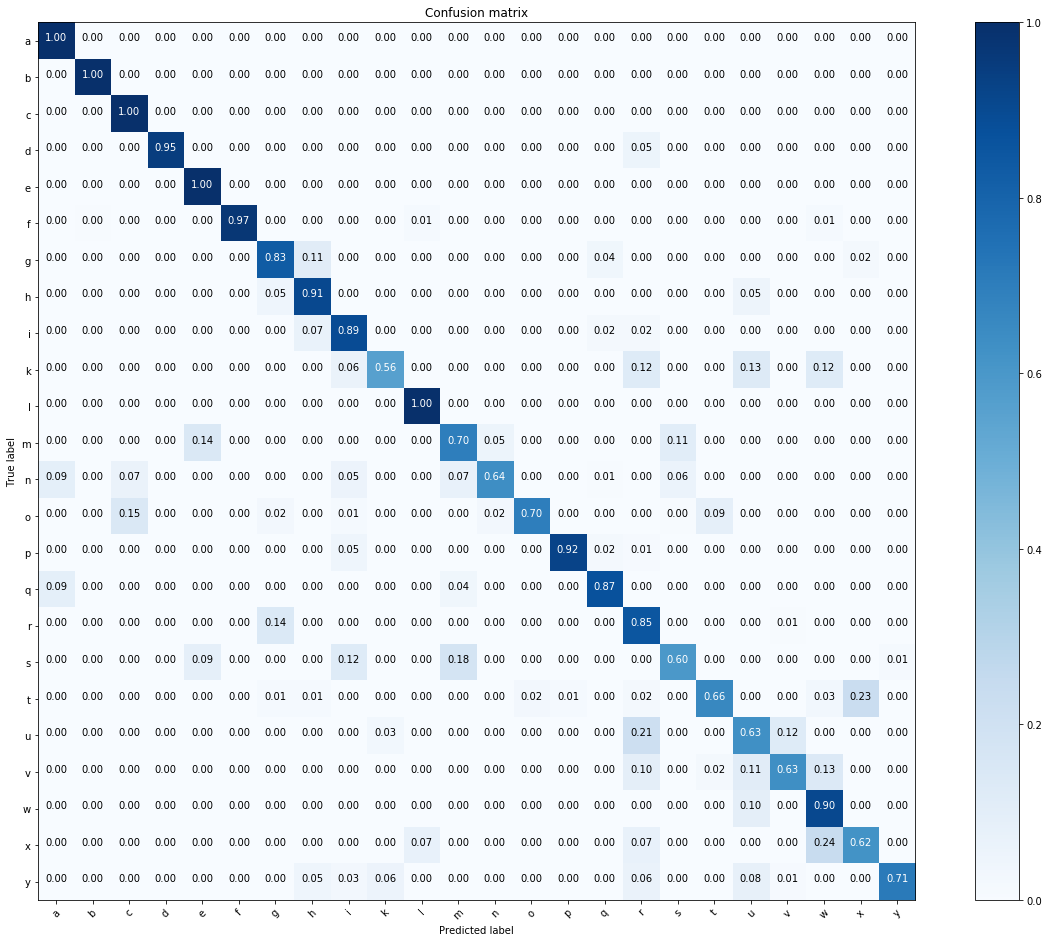

In [44]:
y_precit = model.predict_classes(x_test)
cm = confusion_matrix(y_t, y_precit)

plt.figure(figsize=(17,13))
plot_confusion_matrix(cm, labels_names, normalize=True)
plt.show()

## e) Entrene una SVM no lineal sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como el nivel de regularización aplicado y/o la función de kernel a utilizar.

### 1) Datos escalados

In [135]:
_, x_sub, _, y_sub = train_test_split(x_train, y_tr, test_size=0.13, random_state=42)

In [136]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub, y_sub)
clf.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 63.7min finished


{'C': 1000, 'kernel': 'rbf'}

In [187]:
clf.best_score_

0.96115054165110203

In [227]:
def plot_grid_out(out, c, l):
    x_space = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    pl = ['train', 'test']
    f, axarr = plt.subplots(1, 2, figsize=(17,5))
    for k in range(2):
        axarr[k].set_xscale('log')
        axarr[k].set_xlabel('C')
        axarr[k].set_ylabel('accuracy')
        for i in range(3):
            m = np.array([out['mean_'+pl[k]+'_score'][i+3*j] for j in range(7)])
            s = 2*np.array([out['std_'+pl[k]+'_score'][i+3*j] for j in range(7)])
            axarr[k].grid(True, linestyle='dashed')
            axarr[k].fill_between(x_space, m - s, m + s, alpha=0.25, color=c[i])
            axarr[k].plot(x_space, m, marker='o', linestyle='--', color=c[i], label=pl[k]+' score '+l[i])
            axarr[k].legend(loc='lower right')
    plt.show()

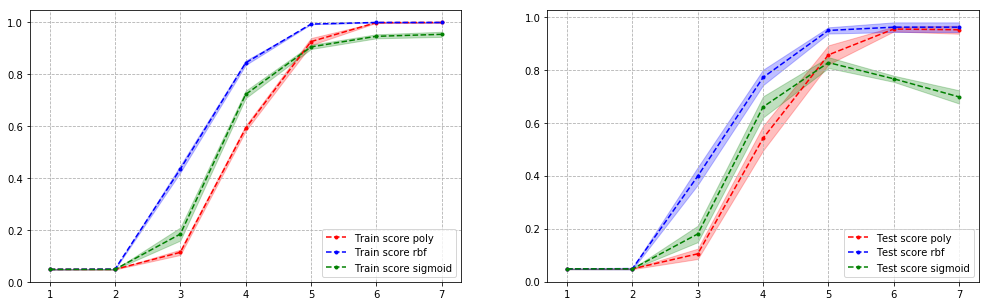

In [190]:
c = ['r', 'b', 'g']
l = ['poly', 'rbf', 'sigmoid']
plot_grid_out(clf.cv_results_, c, l)

### 2) Datos centrados

In [191]:
_, x_sub_center, _, y_sub_center = train_test_split(x_train_center, y_tr, test_size=0.13, random_state=42)

In [192]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_center, y_sub_center)
clf.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 77.2min finished


{'C': 100, 'kernel': 'rbf'}

In [193]:
clf.best_score_

0.93799028763541281

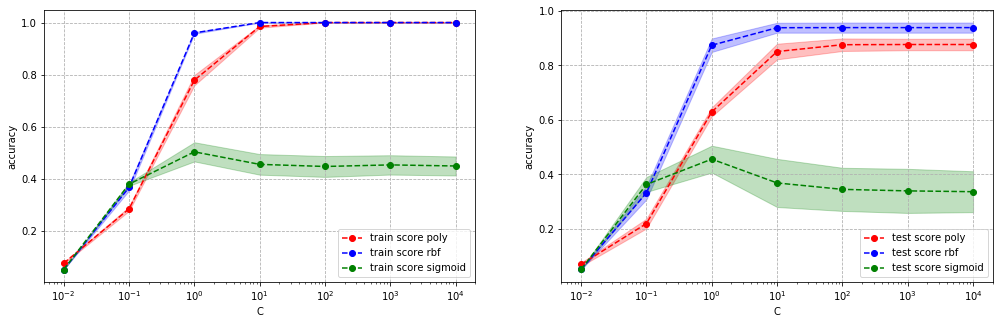

In [228]:
plot_grid_out(clf.cv_results_, c, l)

### 3) Datos sin procesar

In [230]:
_, x_sub_unp, _, y_sub_unp = train_test_split(x_tr, y_tr, test_size=0.13, random_state=42)

In [ ]:
tuned_parameters = [{
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
}]

clf = GridSearchCV(SVM(), tuned_parameters, cv=5, verbose=1, return_train_score=True)
clf.fit(x_sub_unp, y_sub_unp)
clf.best_params_

In [ ]:
clf.best_score_

In [ ]:
plot_grid_out(clf.cv_results_, c, l)

### 4) Modelo final

In [121]:
model = SVM(probability=True)
model.set_params(C=1,kernel='sigmoid', verbose=True)
model.fit(x_sub, y_sub)

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [122]:
y_pred = model.predict(x_train_center)
1-accuracy_score(y_tr, y_pred)

0.77329901413238789

In [123]:
y_pred = model.predict(x_val_center)
1-accuracy_score(y_v, y_pred)

0.77345571095571097

In [124]:
y_pred = model.predict(x_test_center)
1-accuracy_score(y_t, y_pred)

0.77453987730061347

## f) Entrene una árbol de clasificación sobre los pixeles con y sin pre-procesamiento. Puede utilizar el conjunto de validación para seleccionar hiper-parámetros, como la profundidad máxima del árbol.

### 1) Datos escalados

### 2) Datos centrados

### 3) Datos sin procesamiento

### 4) Modelo Final

In [25]:
model = Tree()
#model.set_params(max_depth=param,criterion='gini',splitter='best') #'gini','entropy','variance'
model.fit(x_train, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
model.tree_

In [33]:
y_pred = model.predict(x_test)

In [34]:
from sklearn.metrics               import accuracy_score
1-accuracy_score(y_t, y_pred)

0.58672615727830446

In [9]:
tuned_parameters = [
    {'criterion': ['gini', 'entropy'], 'min_samples_split': [2,4,6,8,10]},
]

clf = GridSearchCV(Tree(), tuned_parameters, cv=5, verbose=1)

In [10]:
clf.fit(x_train, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 37.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [34]:
model = Tree()
model.set_params(criterion='entropy', min_samples_split=2, splitter='best')
model.fit(x_train_ne, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
1-accuracy_score(y_t, model.predict(x_test_ne))

0.55563301728945902

## Extra Conv!

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

In [6]:
X_train = x_tr.reshape(x_tr.shape[0], 28, 28, 1)
X_val = x_v.reshape(x_v.shape[0], 28, 28, 1)
X_test = x_t.reshape(x_t.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_val/=255
X_test/=255

In [7]:
Y_train = to_categorical(y_tr)
Y_val = to_categorical(y_v)
Y_test = to_categorical(y_t)

In [104]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(25))

model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
hist2 = model.fit(X_train, Y_train, batch_size=64, epochs=5,
                  validation_data=(X_val, Y_val), shuffle=True, verbose=1)

Train on 20591 samples, validate on 6864 samples
Epoch 1/5
20591/20591 [==============================] - 166s 8ms/step - loss: 0.2077 - acc: 0.9489 - val_loss: 3.3090 - val_acc: 0.1256
Epoch 2/5
20591/20591 [==============================] - 161s 8ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 3/5
20591/20591 [==============================] - 161s 8ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 5.0268e-04 - val_acc: 1.0000
Epoch 4/5
20591/20591 [==============================] - 160s 8ms/step - loss: 6.4274e-04 - acc: 1.0000 - val_loss: 2.8953e-04 - val_acc: 1.0000
Epoch 5/5
20591/20591 [==============================] - 160s 8ms/step - loss: 4.1831e-04 - acc: 1.0000 - val_loss: 1.6799e-04 - val_acc: 1.0000


In [11]:
scores = model.evaluate(X_test, Y_test)
scores[1] * 100

7172/7172 [==============================] - 21s 3ms/step


96.249302844394862

In [59]:
scores

[7.3279173149453554, 0.037228109313998885]